In [1]:
from model.model import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle
from dataset import ModelNet40Dataset
import numpy as np
import math
%matplotlib inline
from IPython.display import clear_output
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#load data
filehandler = open('ModelNet40ProcessedDataset', 'rb') 
ModelNet40Data = pickle.load(filehandler)

# print(len(ModelNet40Data.train['pcds']))
def sample_data(data,batch_size):
    total_N = len(data['pcds'])
    indices = np.random.choice(total_N,batch_size,replace = False)
    N_pts,d =  data['pcds'][0].shape
    pcds = np.zeros((batch_size,N_pts,d))
    labels = np.zeros(batch_size,dtype=int)
    for i in range(batch_size):
        pcd = data['pcds'][indices[i]]
        #rotate pointcloud
        a = np.random.rand()*math.pi
        R = np.array([[math.cos(a),-math.sin(a),0.],\
              [math.sin(a),math.cos(a),0.],\
              [0.,0.,1.]])
        pcd = pcd.dot(R)
        #jitter
        pcd += np.random.normal(0,0.02,size=pcd.shape)      
        pcds[i,:,:] = pcd
        labels[i] = int(data['labels'][indices[i]])
    return pcds,labels
    
def get_data(data):
    total_N = 600 #len(data['pcds'])
    indices = np.arange(total_N)
    N_pts,d =  data['pcds'][0].shape
    pcds = np.zeros((total_N,N_pts,d))
    labels = np.zeros(total_N,dtype=int)
    for i in range(total_N):
        #rotate and jitter pointcloud
        pcds[i,:,:] = data['pcds'][indices[i]]
        labels[i] = int(data['labels'][indices[i]])
    return pcds,labels

def compute_accuracy(preds,target):
    tmp = preds.max(1).indices == target
    return torch.sum(tmp).detach().cpu().numpy()/target.size(0)


In [3]:
##Hyperparameters
N_CLASSES = 40
EPOCHS = 1000#2000
BATCH_SIZE = 32
INIT_LR = 0.001
MOMENTUM = 0.9
LR_STEP = 20
SCHEDULER_GAMMA = 0.5
TEST_EVERY = 1
REG_WEIGHT = 0.001
criterion = nn.CrossEntropyLoss()

In [4]:
net = PointNetClassification(N_CLASSES).to(device)
optimizer = optim.Adam(params=net.parameters(), lr=INIT_LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=SCHEDULER_GAMMA)


Epoch: 0 ;train and test accuracies: 0.0 0.0
Epoch: 1 ;train and test accuracies: 0.03125 0.0
Epoch: 2 ;train and test accuracies: 0.0 0.03125
Epoch: 3 ;train and test accuracies: 0.125 0.0
Epoch: 4 ;train and test accuracies: 0.125 0.03125
Epoch: 5 ;train and test accuracies: 0.125 0.0
Epoch: 6 ;train and test accuracies: 0.03125 0.03125
Epoch: 7 ;train and test accuracies: 0.09375 0.09375
Epoch: 8 ;train and test accuracies: 0.09375 0.0
Epoch: 9 ;train and test accuracies: 0.1875 0.03125
Epoch: 10 ;train and test accuracies: 0.09375 0.0625
Epoch: 11 ;train and test accuracies: 0.0625 0.03125
Epoch: 12 ;train and test accuracies: 0.09375 0.0
Epoch: 13 ;train and test accuracies: 0.09375 0.0
Epoch: 14 ;train and test accuracies: 0.03125 0.03125
Epoch: 15 ;train and test accuracies: 0.0 0.03125
Epoch: 16 ;train and test accuracies: 0.0 0.0
Epoch: 17 ;train and test accuracies: 0.125 0.09375
Epoch: 18 ;train and test accuracies: 0.15625 0.0
Epoch: 19 ;train and test accuracies: 0.0625 0.

KeyboardInterrupt: 

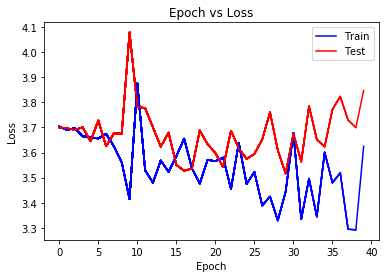

In [5]:
##training loop
train_losses = []
train_iterations = []
test_losses = []
test_iterations = []


for epoch in range(EPOCHS):
    optimizer.zero_grad()
    net.train() 
    #load the batch of data
    data,labels = sample_data(ModelNet40Data.train,BATCH_SIZE)
    data = torch.from_numpy(data).float().to(device)
    labels = torch.from_numpy(labels).to(device)
    
    #compute the loss
    preds,M2 = net(data)
    loss = criterion(preds,labels)
    
    #add transformation matrix regularization loss
    I = torch.eye(64).unsqueeze(0).to(device)
    loss2 = torch.mean(torch.norm(torch.bmm(M2,M2.transpose(2,1)) - I, dim=(1,2)))    
    loss += REG_WEIGHT*loss2
    
    train_losses.append(loss.detach().cpu())
    train_iterations.append(epoch)
    train_accuracy = compute_accuracy(preds,labels)
    #step the optimizer
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch%TEST_EVERY == 0:
        with torch.no_grad():
            net.eval()
            #load the batch of test data (batch size couldn't be too big)
            data,labels = sample_data(ModelNet40Data.test,32)
            data = torch.from_numpy(data).float().to(device)
            labels = torch.from_numpy(labels).to(device)
            
            preds,M2 = net(data)
            test_loss = criterion(preds,labels)
            #add transformation matrix regularization loss
            I = torch.eye(64).unsqueeze(0).to(device)
            test_loss2 = torch.mean(torch.norm(torch.bmm(M2,M2.transpose(2,1)) - I, dim=(1,2)))    
            test_loss += REG_WEIGHT*test_loss2

            test_losses.append(test_loss.detach().cpu())
            test_iterations.append(epoch)
            test_accuracy = compute_accuracy(preds,labels)
            print('Epoch:',epoch, ';train and test accuracies:',train_accuracy,test_accuracy)

#     clear_output()
    plt.plot(train_iterations, train_losses, 'b',test_iterations, test_losses, 'r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend(['Train','Test'])
    plt.title('Epoch vs Loss')
#     plt.show()
    plt.savefig("./cls_losses.png") # save graph for training visualization

In [ ]:
# save stuff
torch.save(net.state_dict(), 'classification_model')

In [ ]:
# ##
# filehandler = open('classification_train_iterations', 'wb') 
# pickle.dump(train_iterations, filehandler)
# filehandler = open('classification_train_losses', 'wb') 
# pickle.dump(train_losses, filehandler)
# filehandler = open('classification_test_iterations', 'wb') 
# pickle.dump(test_iterations, filehandler)
# filehandler = open('classification_test_losses', 'wb') 
# pickle.dump(test_losses, filehandler)